In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
input_size = 3
hidden_sizes = [2, 3] 
output_size = 1
initial_activation_list = [jax.nn.relu]

homo_config = MLPConfig(input_size=input_size,
                        output_size=output_size,
                        hidden_sizes=hidden_sizes,
                        initial_activation_list=initial_activation_list,
                        seed=42)

In [ ]:
mlp = CustomMLP(homo_config)

2024-06-04 12:35:40.116590: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


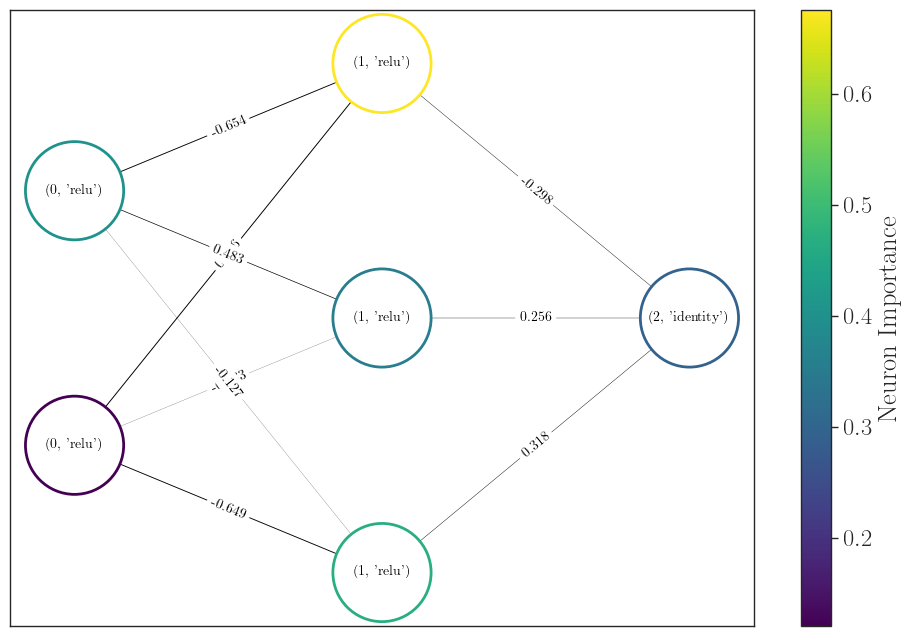

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
mlp = CustomMLP(homo_config)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

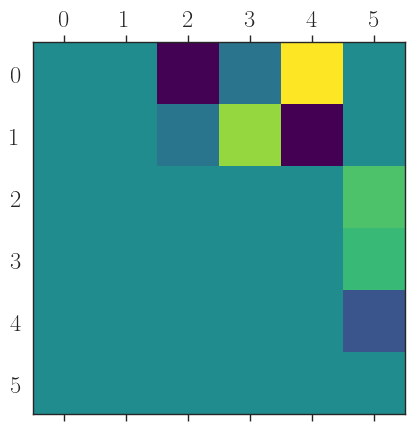

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)

In [ ]:
activation_list = [jax.nn.relu, sin, jax.nn.tanh]
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
key = jax.random.PRNGKey(42)
Loss_history = []
Node_history = []
graph_history = []
Update_history = []
threshold = 1e-8

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:
        if len(Update_history) == 0 or Update_history[-1][2] > loss or Update_history[-1][3] == "removed":
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layers = len(mlp.get_shape()) - 1
            layer = jax.random.randint(act_key, (1,), 0, layers)[0]
            mlp.add_neuron(layer_index=layer, activation=activation, key=add_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer))
            print(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
            print(mlp.get_shape())
        
        elif Update_history[-1][2] < loss:
            # if last addition doesn't improve loss, reject it
            layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
            print(f"Update history: {Update_history[-1]}")
            layer = Update_history[-1][4]
            neuron_idx = len(mlp.layers[layer]) -1

            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer))
            print(f"Rejecting last addition,\n Removed neuron from hidden layer {layer+1} at index {neuron_idx}")
            print(mlp.get_shape())
        
        if loss < threshold:
            # if loss is below threshold, stop training
            print(f"Threshold reached, stopping training at epoch {epoch}")
            break


print("Final Prediction:", mlp(x))

Epoch 0, Prediction: [0.2678956], Loss: 0.5687543153762817
Epoch 1, Prediction: [0.2912943], Loss: 0.5359768867492676
Epoch 2, Prediction: [0.31605446], Loss: 0.5022637248039246
Epoch 3, Prediction: [0.34216866], Loss: 0.4677814841270447
Epoch 4, Prediction: [0.369601], Loss: 0.43274202942848206
Epoch 5, Prediction: [0.39828303], Loss: 0.39740288257598877
Epoch 6, Prediction: [0.42810985], Loss: 0.36206334829330444
Epoch 7, Prediction: [0.45893788], Loss: 0.3270583152770996
Epoch 8, Prediction: [0.49058416], Loss: 0.29274821281433105
Epoch 9, Prediction: [0.5228278], Loss: 0.2595045268535614
Added neuron to hidden layer 2 with activation sin
[2, 4, 1]
Epoch 10, Prediction: [1.2223128], Loss: 0.06113613769412041
Epoch 11, Prediction: [1.2002187], Loss: 0.0494229830801487
Epoch 12, Prediction: [1.180565], Loss: 0.040087517350912094
Epoch 13, Prediction: [1.1630214], Loss: 0.03260371834039688
Epoch 14, Prediction: [1.1473172], Loss: 0.02657599188387394
Epoch 15, Prediction: [1.1332269], L

In [ ]:
Update_history

[(9, 6, Array(0.25950453, dtype=float32), 'sin', Array(1, dtype=int32)),
 (19, 7, Array(0.0097767, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (29, 8, Array(0.00082618, dtype=float32), 'tanh', Array(0, dtype=int32)),
 (39, 9, Array(8.932651e-05, dtype=float32), 'tanh', Array(0, dtype=int32)),
 (49, 10, Array(0.00323857, dtype=float32), 'removed', Array(0, dtype=int32)),
 (59, 9, Array(0.00030053, dtype=float32), 'tanh', Array(0, dtype=int32)),
 (69, 10, Array(4.1566338e-05, dtype=float32), 'relu', Array(0, dtype=int32)),
 (79, 11, Array(2.4305405e-06, dtype=float32), 'tanh', Array(0, dtype=int32)),
 (89,
  12,
  Array(2.2451779e-05, dtype=float32),
  'removed',
  Array(0, dtype=int32)),
 (99, 11, Array(9.241333e-06, dtype=float32), 'relu', Array(1, dtype=int32)),
 (109, 12, Array(5.378397e-07, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (119,
  13,
  Array(3.2649106e-05, dtype=float32),
  'removed',
  Array(1, dtype=int32)),
 (129, 12, Array(1.9849947e-05, dtype=float32), 'si

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

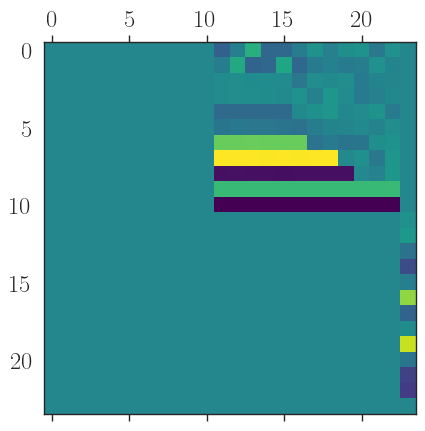

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)

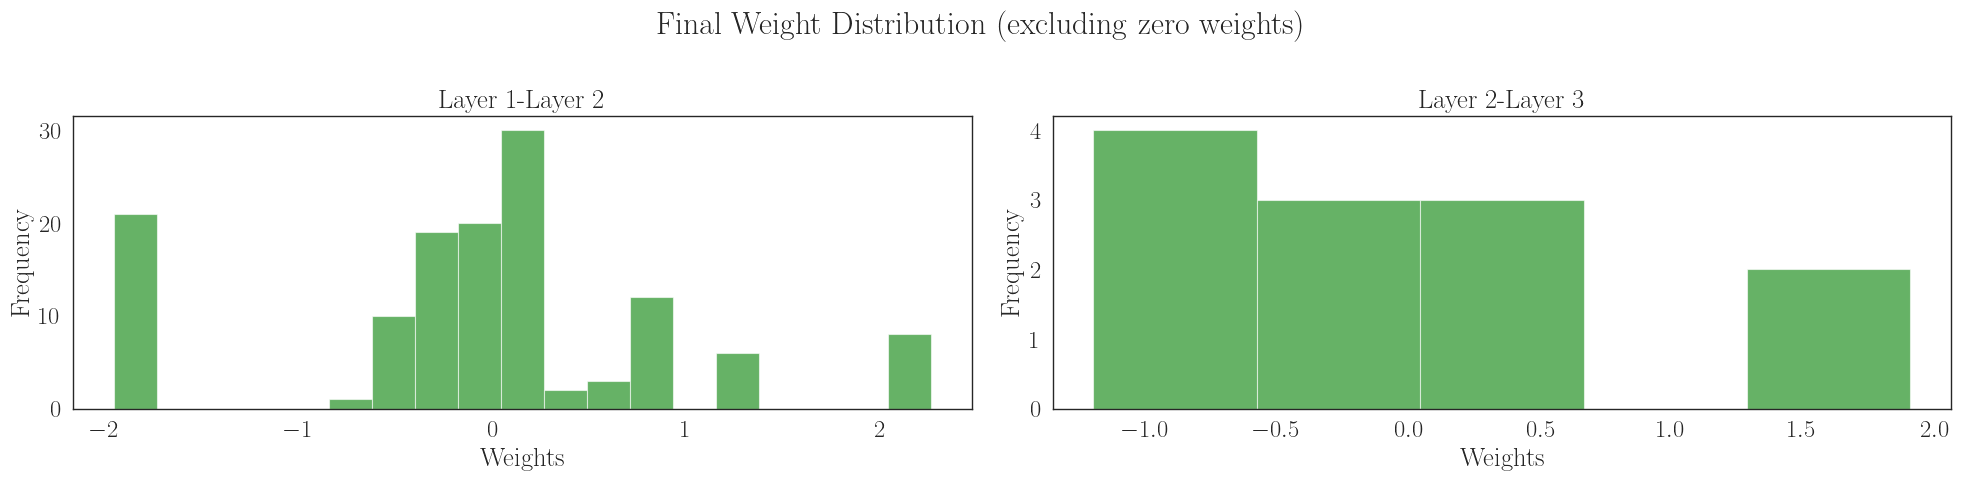

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

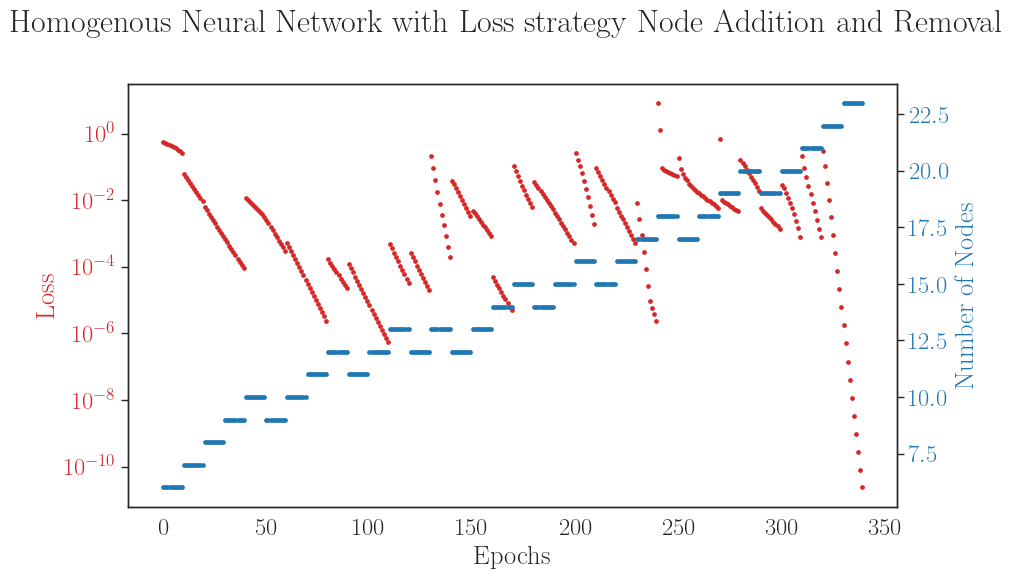

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous Neural Network with Loss strategy Node Addition and Removal")
fig.tight_layout()

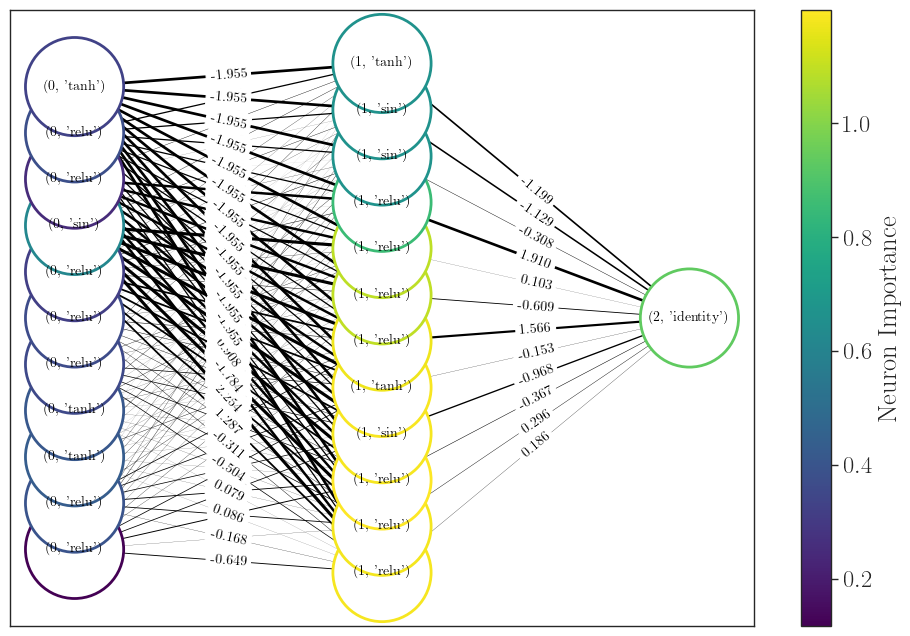

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()